In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
import os
from PIL import Image
from model_params import *
from dataTransformer import *
#tf.disable_v2_behavior()
import time


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [3]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM

seed = 3126
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE

In [4]:


train_ds = image_dataset_from_directory(DATA_ROOT,
                                                       validation_split=validation_split*2,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       subset="training",
                                                       seed=seed)


val_test_ds = image_dataset_from_directory(DATA_ROOT,
                                                       validation_split=validation_split*2,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       subset="validation",
                                                       seed=seed)



Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.


In [5]:
val_ds = val_test_ds.skip(len(val_test_ds)//2)
test_ds = val_test_ds.take(len(val_test_ds)//2)


In [6]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


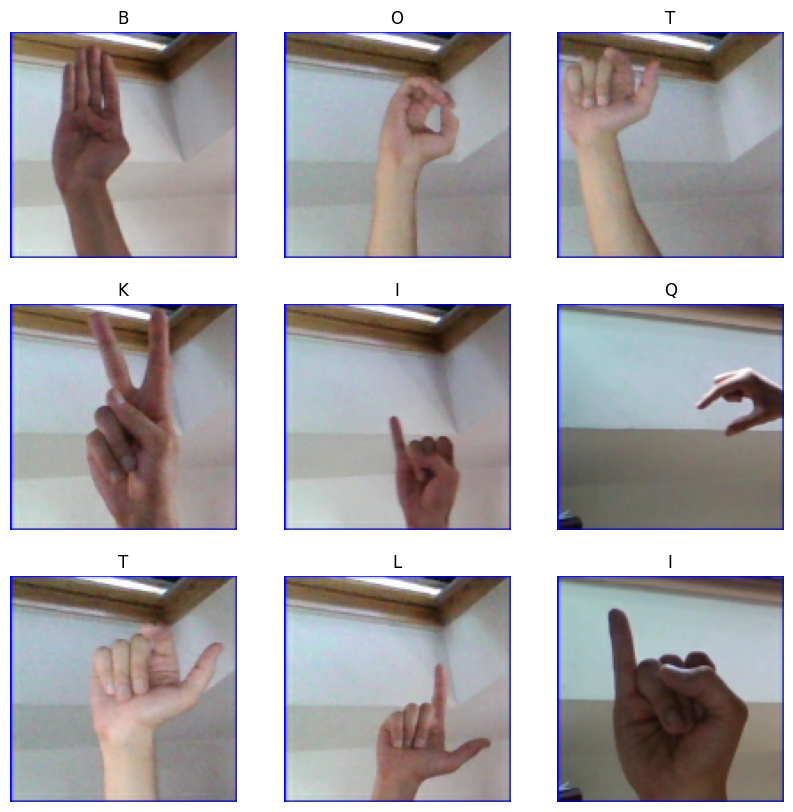

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

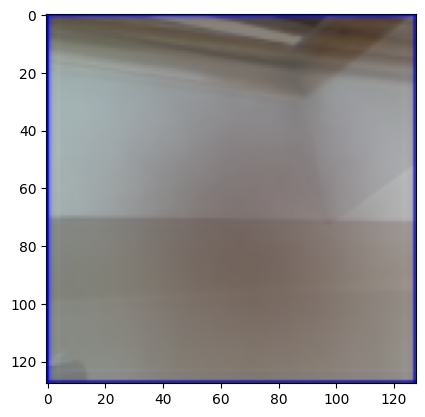

In [8]:
running_mean = tf.zeros(IMG_DIM)
img_num = 0
for imgs, lables in train_ds.take(100):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)/255))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

## Baseline model

Simple linear regression

In [10]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
history = lr_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1632/1632 [==============================] - 14s 8ms/step - loss: 8.4808 - accuracy: 0.1118 - val_loss: 7.9779 - val_accuracy: 0.0957
Epoch 2/3
1632/1632 [==============================] - 7s 4ms/step - loss: 6.8831 - accuracy: 0.1766 - val_loss: 11.7267 - val_accuracy: 0.0858
Epoch 3/3
1632/1632 [==============================] - 6s 4ms/step - loss: 6.2074 - accuracy: 0.2144 - val_loss: 10.9262 - val_accuracy: 0.1073


In [12]:
res = lr_model.evaluate(test_ds)
print("test loss, test acc:", res)

544/544 [==============================] - 4s 7ms/step - loss: 10.8612 - accuracy: 0.1058
test loss, test acc: [10.86119270324707, 0.10575597733259201]


In [13]:
lr_model.save('nn.tf.keras')

## Preprocessing


In [14]:
from dataTransformer import *


transformer =TransformLayer(layers=create_transformation_layer())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


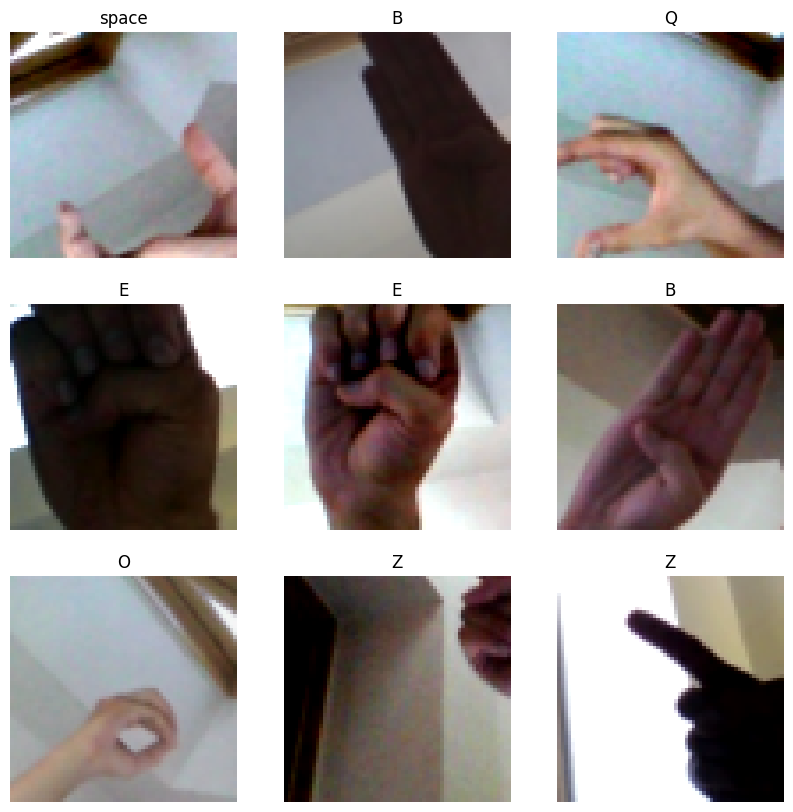

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow( transformer(images[i],training=True).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

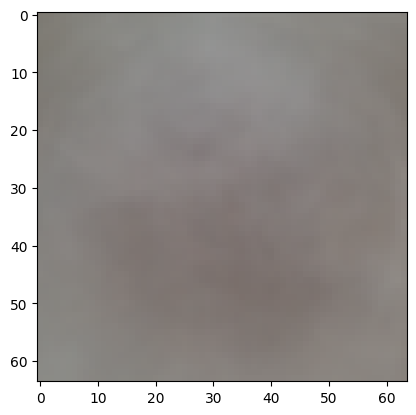

In [16]:
running_mean = tf.zeros(INPUT_SHAPE)
img_num = 0
for imgs, lables in train_ds.take(5):
    newImgs = transformer(imgs,training=True)
    running_mean = (img_num*running_mean+newImgs.shape[0]*(tf.math.reduce_mean(newImgs,0)))/(newImgs.shape[0] + img_num)
    img_num+=newImgs.shape[0]

plt.imshow(running_mean.numpy())

## Neural network

In [17]:
model = tf.keras.Sequential([
  *create_transformation_layer(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1632/1632 [==============================] - 13s 8ms/step - loss: 3.3604 - accuracy: 0.0390 - val_loss: 3.3435 - val_accuracy: 0.0392
Epoch 2/3
1632/1632 [==============================] - 13s 8ms/step - loss: 3.3239 - accuracy: 0.0508 - val_loss: 3.3223 - val_accuracy: 0.0509
Epoch 3/3
1632/1632 [==============================] - 13s 8ms/step - loss: 3.3084 - accuracy: 0.0535 - val_loss: 3.2901 - val_accuracy: 0.0543


In [20]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)

544/544 [==============================] - 5s 9ms/step - loss: 3.2925 - accuracy: 0.0572
test loss, test acc: [3.2925333976745605, 0.05715762823820114]


In [21]:
model.save('neural.keras')

## CNN

In [22]:
from dataTransformer import *

model = tf.keras.Sequential([
  *create_transformation_layer(),
  #tf.keras.layers.Conv2D(32, 7, activation='relu',padding='same'),
  #ResnetBlock(7,16,'res1'),
  tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same',strides=2),#size/2
  ResnetBlock(5,32,'res2'),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same',strides=2),#size/4
  ResnetBlock(3,64,'res3'),
  tf.keras.layers.Conv2D(256, 1, activation='relu', padding='same',strides=2),#size/8
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256*8,activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model = create_model(num_classes,create_transformation_layer())

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
from datetime import datetime

"""6 epoches"""

'6 epoches'

In [30]:
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,profile_batch = '500,520')


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,callbacks = [tboard_callback])


Epoch 1/5
1632/1632 [==============================] - 68s 40ms/step - loss: 0.4652 - accuracy: 0.8453 - val_loss: 0.7293 - val_accuracy: 0.7608
Epoch 2/5
1632/1632 [==============================] - 66s 40ms/step - loss: 0.4146 - accuracy: 0.8615 - val_loss: 0.6068 - val_accuracy: 0.8084
Epoch 3/5
1632/1632 [==============================] - 42s 25ms/step - loss: 0.3764 - accuracy: 0.8752 - val_loss: 0.4069 - val_accuracy: 0.8751
Epoch 4/5
1632/1632 [==============================] - 47s 29ms/step - loss: 0.3514 - accuracy: 0.8820 - val_loss: 0.2818 - val_accuracy: 0.9065
Epoch 5/5
1632/1632 [==============================] - 39s 24ms/step - loss: 0.3205 - accuracy: 0.8937 - val_loss: 0.4527 - val_accuracy: 0.8567


In [31]:
model.save_weights('cnn_RB2_10eW.keras')

In [32]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)

544/544 [==============================] - 6s 11ms/step - loss: 0.4629 - accuracy: 0.8508
test loss, test acc: [0.4628993570804596, 0.8508157134056091]


In [33]:
model.save('cnn6.keras')

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 center_crop_2 (CenterCrop)  (None, 118, 118, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 118, 118, 3)      0         
 tation)                                                         
                                                                 
 random_crop_2 (RandomCrop)  (None, 96, 96, 3)         0         
                                                                 
 resizing_3 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                              

['224', '126', '168', '20240209_022315.jpg']
['236', '208', '249', '20240209_022408.jpg']
['257', '269', '166', '20240209_022330.jpg']
['261', '233', '187', '20240209_022329.jpg']
['270', '255', '212', '20240209_022343.jpg']
['271', '161', '222', '20240209_022328.jpg']
['276', '227', '224', '20240209_022342.jpg']
['279', '242', '153', '20240209_022355.jpg']
['280', '243', '153', '20240209_022354.jpg']
['281', '128', '177', '20240209_022316.jpg']
['281', '239', '157', '20240209_022357.jpg']
['282', '141', '179', '20240209_022318.jpg']
['282', '230', '220', '20240209_022341.jpg']
['283', '138', '180', '20240209_022318.jpg']
['283', '146', '176', '20240209_022320.jpg']
['283', '242', '153', '20240209_022356.jpg']
['285', '129', '176', '20240209_022317.jpg']
['285', '244', '149', '20240209_022357.jpg']
['287', '140', '172', '20240209_022321.jpg']
['288', '144', '176', '20240209_022319.jpg']
['290', '274', '165', '20240209_022345.jpg']
['291', '151', '174', '20240209_022320.jpg']
['293', '2

## Comparison